# Figures Used in the Paper

In [1]:
import torch

# Check if CUDA is available and if PyTorch is using GPU
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")
    
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary(device=0, abbreviated=False))

CUDA is available. Using GPU: NVIDIA GeForce RTX 3080
cuda:1
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|  

## Translation Only

### Plot the Eccentricity

In [2]:
from rnn_model import MNISTRNN

checkpoint_path = "models/2024-11-26_19-52-07/checkpoint_50.pth" # Learned Fovia
# checkpoint_path = "models/2024-12-03_09-10-50/checkpoint_99.pth" # Fixed Lattice

# Hyperparameters
image_size = 100
hidden_size = 512
num_layers = 2
num_classes = 10
batch_size = 64
learning_rate = 0.0002
num_epochs = 100
num_steps = 3  # RNN steps per image
num_kernels = 12*12

model = MNISTRNN(image_size, hidden_size, num_layers, num_classes, num_kernels, device)
model.to(device)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the state dictionary into the model
model.load_state_dict(checkpoint['model_state_dict'])

/tmp/ipykernel_64454/493661265.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


<All keys matched successfully>

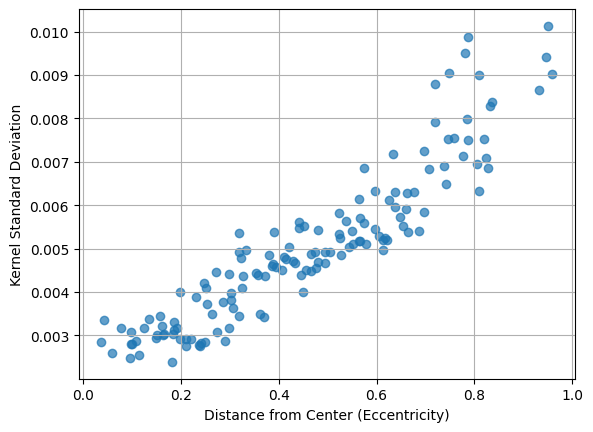

In [3]:
import matplotlib.pyplot as plt
mus = model.eyes.mu
sigmas = model.eyes.sigma
distances = torch.norm(mus, dim=1)

distances = distances.detach().cpu().numpy()
sigmas = sigmas.detach().cpu().numpy() /50

# Plot distances (x-axis) vs sigmas (y-axis)
plt.scatter(distances, sigmas, alpha=0.7)
plt.xlabel('Distance from Center (Eccentricity)')
plt.ylabel('Kernel Standard Deviation')
# plt.title('Distance from Center (Eccentricity)')
plt.grid(True)
plt.show()

### Get The Test Accuracy, Precision, Recall, Model Parameters Size,


In [4]:
import torch
from rnn_model import MNISTRNN

checkpoint_path = "models/2024-11-26_19-52-07/checkpoint_50.pth" # Translation Model
# checkpoint_path = "models/2024-12-03_09-10-50/checkpoint_99.pth" # Fixed Latticce



# Hyperparameters
image_size = 100
hidden_size = 512
num_layers = 2
num_classes = 10
batch_size = 64
learning_rate = 0.0002
num_epochs = 100
num_steps = 3  # RNN steps per image
num_kernels = 12*12

model = MNISTRNN(image_size, hidden_size, num_layers, num_classes, num_kernels, device)
model.to(device)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the state dictionary into the model
model.load_state_dict(checkpoint['model_state_dict'])

/tmp/ipykernel_64454/2904637968.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


<All keys matched successfully>

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score
from dataloaders import get_dataloaders
import torch
# Assuming get_dataloaders() provides train and test loaders
train_loader, test_loader = get_dataloaders()

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        batch_size = images.size(0)
        h0 = torch.zeros(num_layers, batch_size, hidden_size).to(images.device)
        next_actions = torch.zeros((batch_size, 2), device=images.device)
        
        for step in range(num_steps):
            class_pred, action_pred, h0, sensor_readings = model(images, next_actions, h0)
            next_actions = action_pred

        _, predicted = torch.max(class_pred.data, 1)
        
        # Append for metric calculations
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        # Accuracy calculation
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model):,}")


Accuracy of the model on the test images: 92.20%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Number of trainable parameters: 868,796


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model):,}")

### Do a few rollouts

In [6]:
from glimpse import plot_glimpse_image
train_loader, test_loader = get_dataloaders()

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        batch_size = images.size(0)

        # Initialize the hidden state and center
        h0 = torch.zeros(num_layers, batch_size, hidden_size).to(images.device)
        
        next_actions = torch.zeros((batch_size, 2), device=images.device)

        loss = 0
        for step in range(num_steps):
            # Print the image out
            
            # next_actions = torch.zeros_like(next_actions, device=next_actions.device) #TODO: remove this line please
            # Forward pass    
            class_pred, action_pred, h0, sensor_readings = model(images, next_actions, h0)
            
            if (i + 1) % 1 == 0:
                sz = torch.ones((1), device=device)
                img = images[0][0]
                sc = next_actions[0][0:2] 
                # sz = (actions[:, 2] + 1)*3
                sz = 1
                img_name = f"iter{i+1}_step{step}.png"
                plot_glimpse_image(img_name, img, model.eyes.mu, model.eyes.sigma, sc, sz, sensor_readings[0])
                
            next_actions = action_pred